# Amplifying Noise on Optimized VQE Circuit (H2 at 0.74 ang via Simulator) by random addition of both single and 2 qubit gates.

# Also amplifyig readout errors

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

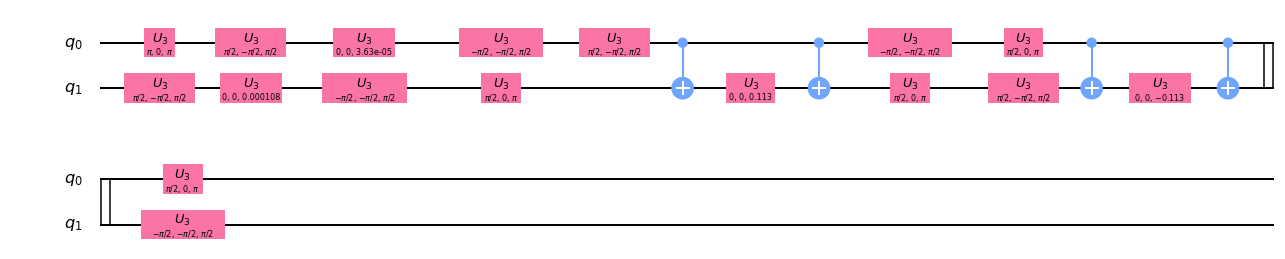

In [2]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
vqe_circ.draw(output = 'mpl')

### Functions for Noise Amplification

In [3]:
def u3PairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    # Converting the gate string to array 
    
    ##break up the string 
    strings = orig_gate_str.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    
    #Obtaining all useful information 
    gate = strings[0]
    qubit = strings[4]
    orig_angles = strings[1:4]
    
    #new angles 
    new_angles = orig_angles 
    
    ## U3 ^-1(  theta,  phi, lambda) = U3( theta , -pi - lambda, - pi - phi)
    
    ###Part 1: Inverting and adding - pi to 2nd and 3rd angle
    for i in range(1,3): 
        if new_angles[i][0] == '-': 
            
            if new_angles[i] == '-pi': 
                new_angles[i] = str(-math.pi +math.pi)
            elif new_angles[i] == '-pi/2': 
                new_angles[i] = str(-math.pi +(math.pi/2))
            else:
                new_angles[i] = str(-math.pi +float(new_angles[i][1:]))
        else: 
            if new_angles[i] == 'pi': 
                new_angles[i] = str(-math.pi -math.pi)
            elif new_angles[i] == 'pi/2': 
                new_angles[i] = str(-math.pi -(math.pi/2))
            else:
                new_angles[i] = str(-math.pi+ (-1)*float(new_angles[i]))
    ###Part 2: Switching the 2nd and 3rd angles
    new_angles = [new_angles[0], new_angles[2], new_angles[1]]
            

    #creating inverted gate
    new_gate_str = gate + '(' + new_angles[0] + ',' + new_angles[1] + ',' + new_angles[2] + ')' + qubit
    
    #barrier 
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n'
    

In [4]:
def cXPairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    #barrier for 2 qubit circuit only
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n'

In [5]:
import random 

def RandomAmplification(circ, c): 
    """
    Input: a circuit, and scaling factor between 1 and 3 (inclusive)
    Output: circuit with amplified error rate using adding-pair-of-gates tactic
    """
    
    #probability to add a pair of gates 
    g = (c-1)/4
    
    #iterating over the circuit in string representation
    
    
    newqasm_str=""
    circ_str=circ.qasm()
    
    qregname=circ.qregs[0].name
    
    for line in iter(circ_str.splitlines()):
        
        if line.startswith('cx') or line.startswith('u3'):
            
            #doing a toss to see if we have to amplify 
            if random.randint(1,101) <= 100*g : 
                
                #adding the original line first 
                ##barrier 
                barrier ="""barrier q[0],q[1];"""
                newqasm_str+= barrier + '\n' + line + '\n'+ barrier + '\n'
                if line.startswith('cx'):
                    newqasm_str += cXPairAdder(line)
                else: 
                    newqasm_str += u3PairAdder(line)
            else: 
                newqasm_str+=line+"\n"
        else:
            newqasm_str+=line+"\n"

    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
    return circo 


### Functions for Readout Error Amplification

In [6]:
def one_qubit_readout_error_matrix(qubit_n, scale = 1):
    """
    Input: which qubit on the london device, scale (for noise scaling)
    Generates the readout error matrix
    
    organized as 
    
    P(0|0)  P(0|1)
    P(1|0)  P(1|1)
    
    """
    if (qubit_n == 0): 
        errors = [0.013333333333333334, 0.073]
    elif (qubit_n == 1): 
        errors = [0.02, 0.0449]
    x, y = errors
    x = scale*x
    y = scale*y
    
    matrix = [[1-x, y], [x, 1-y]]
    
    return matrix

def column_sum_to_1(matrix): 
    """
    Makes sure that columns of a 2x2 matrix sum to 1
    """
    matrix = np.transpose(matrix)
    
    for r in range(len(matrix)):
        summ = 0
        for c in range(len(matrix[r])):
            summ += matrix[r][c]
        for c in range(len(matrix[r])): 
            matrix[r][c] = (matrix[r][c])/summ
            
    matrix = np.transpose(matrix)
    return matrix
        

def two_qubit_readout_error_matrix(mat_1, mat_2):
    """
    Input: corresponding readout error matrices of the 2 qubits
    Output: their kronecker product
    """
    P = mat_1
    Q = mat_2
    
    matrix = column_sum_to_1(np.kron(P,Q))
    return matrix

def get_2_qubit_readout_matrix_regular(scale): 
    """
    for amplifying readout errors
    """
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(1, scale)
    Q_scale = one_qubit_readout_error_matrix(0, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    return R_scale

def get_2_qubit_readout_matrix_after_readout_measurement(scale): 
    """
    for amplifying readout errors
    """
    #what already happened
    P_1 = one_qubit_readout_error_matrix(1)
    Q_1 = one_qubit_readout_error_matrix(0)
    R_1 = two_qubit_readout_error_matrix(P_1, Q_1)
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(1, scale)
    Q_scale = one_qubit_readout_error_matrix(0, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    #what then needs to happen 
    """
    XR_1 = R_scale
    X = R_scale*(R_1)^-1
    """
    inverse = np.linalg.inv(R_1)
    X = np.dot(R_scale, inverse)
    
    return X

def counts_to_array(counts): 
    """
    Turning counts (dict) to array format ...for matrix multiplication
    """
    array = [[counts['00']],[counts['01']], [counts['10']], [counts['10']] ]
    return array
def array_to_counts(array, shots = 1024):
    """
    Turning array into counts(dict)
    """
    #making sure the array has correct number of shots
    summ = 0
    for i in array: 
        summ+=i
    new_array = [(i/summ)*1024 for i in array]
    
    counts = {'00': float(new_array[0]), '01': float(new_array[1]), '10':float(new_array[2]), '11': float(new_array[3])}
    
    return counts

def counts_after_readout_amp(counts, scale):
    """
    Input: Counts, amplification factor
    Output: modified counts
    """
    array = counts_to_array(counts)
    matrix = get_2_qubit_readout_matrix_after_readout_measurement(scale)
    new_array = np.dot(matrix, array)
    
    return array_to_counts(new_array)

### Hammyfication: Breaking Circuits into 2 copies, 1 for II, IZ, ZI and ZZ and the other for XX

In [7]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [8]:
less_circuits = [circuits[0], circuits[4]]

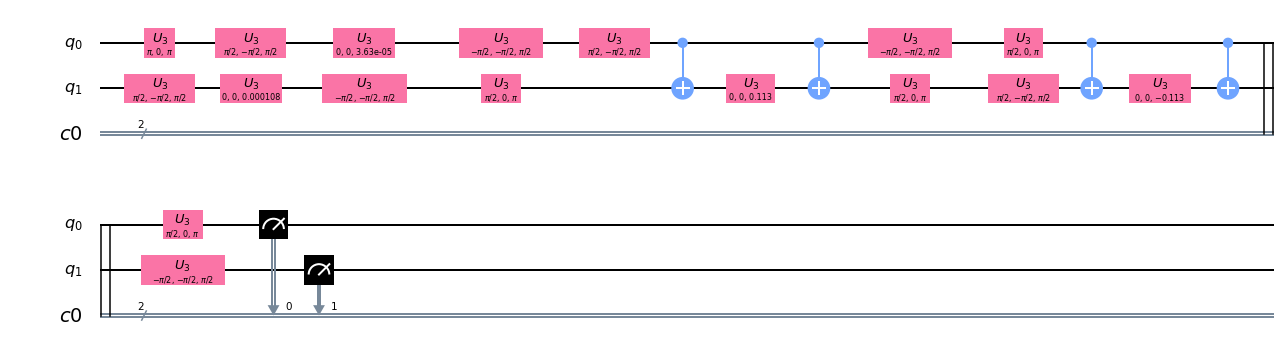

In [9]:
less_circuits[0].draw(output = 'mpl')

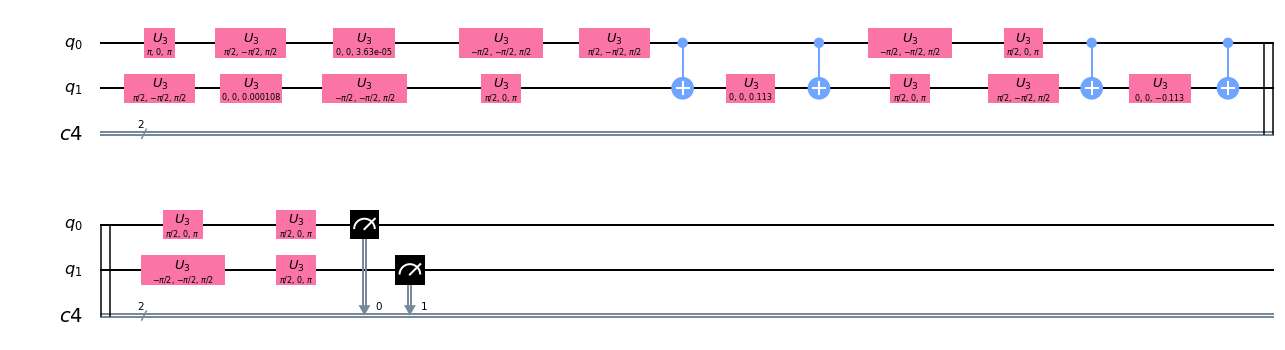

In [10]:
less_circuits[1].draw(output = 'mpl')
#hadamrd in u3 language

### Noise Amplification of Circuits

In [11]:
lots_scaled_circuits = []
n_samples = 1000
scales = [1,1.5,2,2.5,3, 3.5, 4,4.5, 5]

for c in scales:
    scale_circs = []
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in less_circuits: 
        hammyfied_circs = []
        print( "Starting Hammified Circ")
        for i in range(n_samples):
            combo_circ = []
            circ = hammyfied_circ.copy()
            amp_circ = RandomAmplification(circ, c)
            hammyfied_circs.append(amp_circ)
        scale_circs.append(hammyfied_circs)
    lots_scaled_circuits.append(scale_circs)

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 1.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 4.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 5 

### Expectation Value Functions

In [12]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [13]:
def get_expec_val_H2(results, h, shots = 1024):
    keys = results.keys()
    e_val = 0
    for key in keys:
        counts =int(results[key])
        
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

### Running Circuits

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import QuantumError, ReadoutError, depolarizing_error
import numpy as np

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_london')
noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')

basis_gates = noise_model.basis_gates

In [15]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

#creating gate errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)


#creating readout error
P =  np.transpose(one_qubit_readout_error_matrix(0))
Q = np.transpose(one_qubit_readout_error_matrix(1))

#readout_error = ReadoutError(probabilities)
readout_error_1 = ReadoutError(P)
readout_error_2 = ReadoutError(Q)

#adding all the errors 


# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])


#now adding readout error 
noise_model.add_readout_error(readout_error_1, [0])
noise_model.add_readout_error(readout_error_2, [1])

#### Running Function

In [16]:
def evaluator(circuits, noise_model = None, 
              weights =  [-1.053, 0.395, -0.395, -0.011, 0.181], readout_amp = False, scale = 1):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = []
    for circ in circuits: 
        circ = transpile(circ, basis_gates = basis_gates)
        job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
        result = job.result().get_counts()
        results.append(result)
        
    #Amping up readout errors
    if (readout_amp): 
        for i in range(len(results)): 
            results[i] = counts_after_readout_amp(results[i], scale)
    
    #Converting counts to expec values of local hammys
    
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    hammyfied_vals = []
    for i in range(n): 
        if (i <4):
            c = 0
        else: 
            c= 1
        hammyfied_val = get_expec_val_H2(results[c], i)
        hammyfied_vals.append(hammyfied_val)
    
    #Combining expectation values of local hamiltonians with the weights and adding nuclear repulsion energy
    
    shift = 0.7151043390810812
    expec_val = 0 + shift
    for i in range(len(hammyfied_vals)): 
        expec_val += weights[i]*hammyfied_vals[i]
        
    return expec_val
    

In [17]:
import numpy as np
from qiskit import execute 
from qiskit.compiler import transpile 
from qiskit.tools.monitor import job_monitor

lots_scaled_results = []
means = []
std_devs = []
err_on_means = []

for s in range(len(scales)):
    
    scale_circs = lots_scaled_circuits[s]
    scale = scales[s]
    
    print('------------------------------Starting Scale ' +str(scale) +'---------------------')
    energies = []
    
    #going over all samples, 1 from iz,Zz,zi,ii box and 1 from xx branch 
    hammy_box_1 = scale_circs[0]
    hammy_box_2 = scale_circs[1]
    
    for i in range(n_samples):
        energy = evaluator([hammy_box_1[i], hammy_box_2[i]], noise_model, readout_amp = True, scale = scale)
        energies.append(energy)
    
    #adding results to means, std_dves
    means.append(np.mean(energies))
    std_devs.append(np.std(energies))
    err_on_means.append(np.std(energies)/np.sqrt(len(energies)))


------------------------------Starting Scale 1---------------------
------------------------------Starting Scale 1.5---------------------
------------------------------Starting Scale 2---------------------
------------------------------Starting Scale 2.5---------------------
------------------------------Starting Scale 3---------------------
------------------------------Starting Scale 3.5---------------------
------------------------------Starting Scale 4---------------------
------------------------------Starting Scale 4.5---------------------
------------------------------Starting Scale 5---------------------


In [18]:
means 

[-0.9785098367001688,
 -0.9182290798642313,
 -0.8613802322079812,
 -0.8079686384579814,
 -0.7537573230282938,
 -0.7059826101376687,
 -0.6585936199032938,
 -0.6149629206845437,
 -0.5717607136532938]

In [19]:
std_devs

[0.014388686207374598,
 0.034069734774125685,
 0.04217328797993561,
 0.04278626637254914,
 0.04073480433175139,
 0.03821808079948171,
 0.03304957770044469,
 0.0241363117094252,
 0.014438498065928007]

In [20]:
err_on_means

[0.0004550102095275358,
 0.0010773796116407945,
 0.0013336364643479802,
 0.0013530205431192572,
 0.0012881476172962754,
 0.0012085618312671108,
 0.001045119412401153,
 0.0007632571931757578,
 0.0004565853988026849]

### Plotting Results

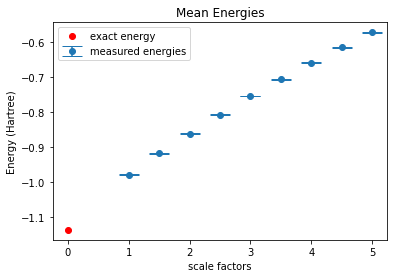

In [21]:
import matplotlib.pyplot as plt
#Plotting the results 
vqe_mean = means
vqe_std = std_devs
vqe_err  = err_on_means

#Plotting means 
plt.figure()
plt.errorbar(scales, vqe_mean, yerr=vqe_err,capsize = 10, fmt ='o', label = 'measured energies' )
plt.plot(0, -1.137, 'ro', label = 'exact energy')

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()